# Forecasting: univariate, heavy tailed

This tutorial introduces the [pyro.contrib.forecast](http://docs.pyro.ai/en/latest/contrib.forecast.html) module, a framework for forecasting with Pyro models. This tutorial covers only univariate models and simple likelihoods. This tutorial assumes the reader is already familiar with [SVI](http://pyro.ai/examples/svi_part_ii.html) and [tensor shapes](http://pyro.ai/examples/tensor_shapes.html).

#### Summary
- To create a forecasting model:
  1. Create a subclass of the [ForecastingModel](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.forecaster.ForecastingModel) class.
  2. Implement the [.model(zero_data, covariates)](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.forecaster.ForecastingModel.model) method using standard Pyro syntax.
  3. Sample all time-local variables inside the [self.time_plate](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.forecaster.ForecastingModel.time_plate) context.
  4. Finally call the [.predict(noise_dist, prediction)](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.forecaster.ForecastingModel.predict) method.
- To train a forecasting model, create a [Forecaster](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.forecaster.Forecaster) object.
  - Training can be flaky, you'll need to tune hyperparameters and randomly restart.
  - Reparameterization can help learning, e.g. [LocScaleReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.loc_scale.LocScaleReparam).
- To forecast the future, draw samples from a `Forecaster` object conditioned on data and covariates.
- To model seasonality, use helpers [periodic_features()](http://docs.pyro.ai/en/latest/ops.html#pyro.ops.tensor_utils.periodic_features), [periodic_repeat()](http://docs.pyro.ai/en/latest/ops.html#pyro.ops.tensor_utils.periodic_repeat), and [periodic_cumsum()](http://docs.pyro.ai/en/latest/ops.html#pyro.ops.tensor_utils.periodic_cumsum).
- To model heavy-tailed data, use [Stable](http://docs.pyro.ai/en/latest/distributions.html#stable) distributions and [StableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.StableReparam).
- To evaluate results, use the [backtest()](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.evaluate.eval_crps) helper or low-level loss functions.

In [1]:
import torch
import pyro
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.contrib.examples.bart import load_bart_od
from pyro.contrib.forecast import ForecastingModel, Forecaster, backtest, eval_crps
from pyro.infer.reparam import LocScaleReparam, StableReparam
from pyro.ops.tensor_utils import periodic_cumsum, periodic_repeat, periodic_features
from pyro.ops.stats import quantile
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.rc = {'figure.facecolor': (1, 1, 1, 1)}
%config InlineBackend.figure_formats = ['svg']
assert pyro.__version__.startswith('1.2.1')
pyro.enable_validation(True)
pyro.set_rng_seed(20200221)

In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
torch.Size([78888, 50, 50])
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


## Intro to Pyro's forecasting framework

Pyro's forecasting framework consists of:
- a [ForecastingModel](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.forecaster.ForecastingModel) base class, whose ``.model()`` method can be implemented for custom forecasting models,
- a [Forecaster](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.forecaster.Forecaster) class that trains and forecasts using ``ForecastingModel``s, and
- a [backtest()](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.evaluate.backtest) helper to evaluate models on a number of metrics.

Consider a simple univariate dataset, say weekly [BART train](https://www.bart.gov/about/reports/ridership) ridership aggregated over all stations in the network. This data roughly logarithmic, so we log-transform for modeling.

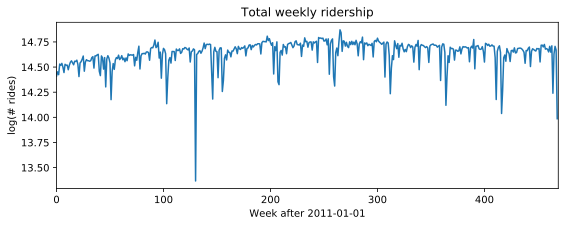

In [3]:
T, O, D = dataset["counts"].shape
data = dataset["counts"][:T // (24 * 7) * 24 * 7].reshape(T // (24 * 7), -1).sum(-1).log()
data = data.unsqueeze(-1)
plt.figure(figsize=(9, 3))
plt.plot(data)
plt.title("Total weekly ridership")
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, len(data));

Let's start with a simple log-linear regression model, with no trend or seasonality. Note that while this example is univariate, Pyro's forecasting framework is multivariate, so we'll often need to reshape using `.unsqueeze(-1)`, `.expand([1])`, and `.to_event(1)`.

In [4]:
# First we need some boilerplate to create a class and define a .model() method.
class Model1(ForecastingModel):
    # We then implement the .model() method. Since this is a generative model, it shouldn't
    # look at data; however it is convenient to see the shape of data we're supposed to
    # generate, so this inputs a zeros_like(data) tensor instead of the actual data.
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)  # Should be 1 in this univariate tutorial.
        feature_dim = covariates.size(-1)

        # The first part of the model is a probabilistic program to create a prediction.
        # We use the zero_data as a template for the shape of the prediction.
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))
        prediction = bias + (weight * covariates).sum(-1, keepdim=True)
        # The prediction should have the same shape as zero_data (duration, obs_dim),
        # but may have additional sample dimensions on the left.
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters, and again we'll use zero_data as a noise template.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(zero_data, noise_scale)

        # The final step is to call the .predict() method.
        self.predict(noise_dist, prediction)

We can now train this model by creating a [Forecaster](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.forecaster.Forecaster) object. We'll split the data into `[T0,T1)` for training and `[T1,T2)` for testing.

In [5]:
T0 = 0              # begining
T2 = data.size(-2)  # end
T1 = T2 - 52        # train/test split

In [6]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = torch.stack([time], dim=-1)
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 484401
INFO 	 step  100 loss = 0.609042
INFO 	 step  200 loss = -0.535144
INFO 	 step  300 loss = -0.605789
INFO 	 step  400 loss = -0.59744
INFO 	 step  500 loss = -0.596203
INFO 	 step  600 loss = -0.614217
INFO 	 step  700 loss = -0.612415
INFO 	 step  800 loss = -0.613236
INFO 	 step  900 loss = -0.59879
INFO 	 step 1000 loss = -0.601271


CPU times: user 4.88 s, sys: 73.2 ms, total: 4.95 s
Wall time: 4.99 s


Next we can evaluate by drawing posterior samples from the forecaster, passing in full covariates but only partial data. We'll use Pyro's [quantile()](http://docs.pyro.ai/en/latest/ops.html#pyro.ops.stats.quantile) function to plot median and an 80% confidence interval. To evaluate fit we'll use [eval_crps()](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.evaluate.eval_crps) to compute [Continuous Ranked Probability Score](https://www.stat.washington.edu/raftery/Research/PDF/Gneiting2007jasa.pdf); this is an good metric to assess distributional fit of a heavy-tailed distribution.

torch.Size([1000, 52, 1]) torch.Size([52])


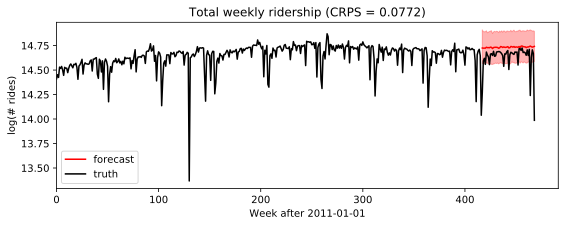

In [7]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])
print(samples.shape, p10.shape)

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

Zooming in to just the forecasted region, we see this model ignores seasonal behavior.

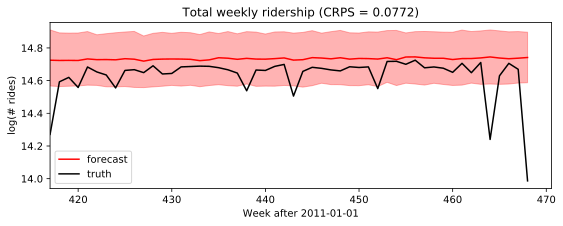

In [8]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

We could add a yearly seasonal component simply by adding new covariates (note we've already taken care in the model to handle `feature_dim > 1`).

In [9]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = torch.cat([time.unsqueeze(-1),
                        periodic_features(T2, 365.25 / 7)], dim=-1)
forecaster = Forecaster(Model1(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 53174.4
INFO 	 step  100 loss = 0.519148
INFO 	 step  200 loss = -0.0264822
INFO 	 step  300 loss = -0.314983
INFO 	 step  400 loss = -0.413243
INFO 	 step  500 loss = -0.487756
INFO 	 step  600 loss = -0.472516
INFO 	 step  700 loss = -0.595866
INFO 	 step  800 loss = -0.500985
INFO 	 step  900 loss = -0.558623
INFO 	 step 1000 loss = -0.589603


CPU times: user 5.33 s, sys: 108 ms, total: 5.44 s
Wall time: 5.42 s


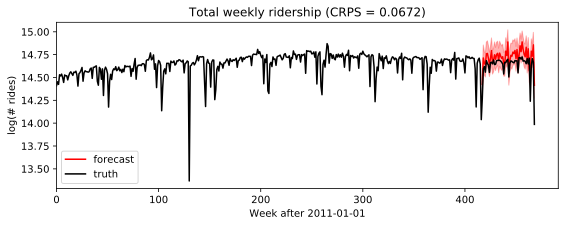

In [10]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

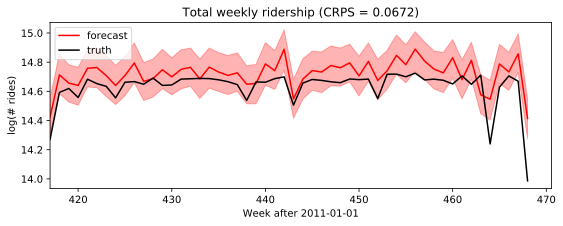

In [11]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

## Time-local random variables: `self.time_plate`

So far we've seen the ``ForecastingModel.model()`` method and ``self.predict()``. The last piece of forecasting-specific syntax is the ``self.time_plate`` context for time-local variables. To see how this works, consider changing our global linear trend model above to a local level model. Note the [poutine.reparam()](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) handler is a general Pyro inference trick, not specific to forecasting.

In [12]:
class Model2(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        # We'll sample a time-global scale parameter outside the time plate,
        # then time-local iid noise inside the time plate.
        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            # We'll use a reparameterizer to improve variational fit. The model would still be
            # correct if you removed this context manager, but the fit appears to be worse.
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))

        # After we sample the iid "drift" noise we can combine it in any time-dependent way.
        # It is important to keep everything inside the plate independent and apply depedent
        # transforms outside the plate.
        motion = drift.cumsum(-2)  # A Brownian motion.
    
        # The prediction now includes three terms.
        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape
    
        # Construct the noise distribution and predict.
        noise_scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Normal(zero_data, noise_scale)
        self.predict(noise_dist, prediction)            

In [13]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 7)
forecaster = Forecaster(Model2(), data[:T1], covariates[:T1], learning_rate=0.1)

INFO 	 step    0 loss = 1.7326e+09
INFO 	 step  100 loss = 0.902688
INFO 	 step  200 loss = -0.0639999
INFO 	 step  300 loss = -0.102488
INFO 	 step  400 loss = -0.301241
INFO 	 step  500 loss = -0.404315
INFO 	 step  600 loss = -0.365754
INFO 	 step  700 loss = -0.429714
INFO 	 step  800 loss = -0.447207
INFO 	 step  900 loss = -0.515883
INFO 	 step 1000 loss = -0.519698


CPU times: user 9.03 s, sys: 91.1 ms, total: 9.12 s
Wall time: 9.18 s


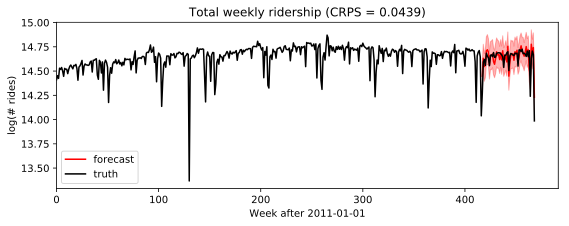

In [14]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

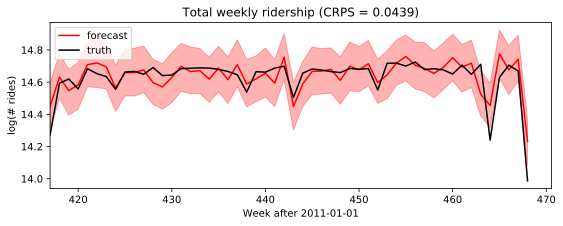

In [15]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

## Heavy-tailed noise

Our final univariate model will generalize from Gaussian noise to heavy-tailed [Stable](http://docs.pyro.ai/en/latest/distributions.html#stable) noise. The only difference is the `noise_dist` which now takes two new parameters: `stability` determines tail weight and `skew` determines the relative size of positive versus negative spikes.

The [Stable distribution](https://en.wikipedia.org/wiki/Stable_distribution) is a natural heavy-tailed generalization of the Normal distribution, but it is difficult to work with due to its intractible density function. Pyro implements auxiliary variable methods for working with Stable distributions. To inform Pyro to use those auxiliary variable methods, we wrap the final line in [poutine.reparam()](http://docs.pyro.ai/en/latest/poutine.html#pyro.poutine.handlers.reparam) effect handler that applies the [StableReparam](http://docs.pyro.ai/en/latest/infer.reparam.html#pyro.infer.reparam.stable.StableReparam) transform to the implicit observe site named "residual". You can use Stable distributions for other sites by specifying `config={"my_site_name": StableReparam()}`.

In [16]:
class Model3(ForecastingModel):
    def model(self, zero_data, covariates):
        data_dim = zero_data.size(-1)
        feature_dim = covariates.size(-1)
        bias = pyro.sample("bias", dist.Normal(0, 10).expand([data_dim]).to_event(1))
        weight = pyro.sample("weight", dist.Normal(0, 0.1).expand([feature_dim]).to_event(1))

        drift_scale = pyro.sample("drift_scale", dist.LogNormal(-20, 5).expand([1]).to_event(1))
        with self.time_plate:
            with poutine.reparam(config={"drift": LocScaleReparam()}):
                drift = pyro.sample("drift", dist.Normal(zero_data, drift_scale).to_event(1))
        motion = drift.cumsum(-2)  # A Brownian motion.
        
        prediction = motion + bias + (weight * covariates).sum(-1, keepdim=True)
        assert prediction.shape[-2:] == zero_data.shape

        # The next part of the model creates a likelihood or noise distribution.
        # Again we'll be Bayesian and write this as a probabilistic program with
        # priors over parameters, and again we'll use zero_data as a noise template.
        stability = pyro.sample("noise_stability", dist.Uniform(1, 2).expand([1]).to_event(1))
        skew = pyro.sample("noise_skew", dist.Uniform(-1, 1).expand([1]).to_event(1))
        scale = pyro.sample("noise_scale", dist.LogNormal(-5, 5).expand([1]).to_event(1))
        noise_dist = dist.Stable(stability, skew, scale, zero_data)

        # We need to use a reparameterizer to handle the Stable distribution.
        # Note "residual" is the name of Pyro's internal sample site in self.predict().
        with poutine.reparam(config={"residual": StableReparam()}):
            self.predict(noise_dist, prediction)            

In [17]:
%%time
pyro.set_rng_seed(2)
pyro.clear_param_store()
time = torch.arange(float(T2)) / 365
covariates = periodic_features(T2, 365.25 / 7)
forecaster = Forecaster(Model3(), data[:T1], covariates[:T1], learning_rate=0.1)
for name, value in forecaster.guide.median().items():
    if value.numel() == 1:
        print("{} = {:0.4g}".format(name, value.item()))

INFO 	 step    0 loss = 5.92062e+07
INFO 	 step  100 loss = 13.5949
INFO 	 step  200 loss = 3.0411
INFO 	 step  300 loss = 0.866627
INFO 	 step  400 loss = 0.362264
INFO 	 step  500 loss = 0.0508628
INFO 	 step  600 loss = -0.236901
INFO 	 step  700 loss = -0.290881
INFO 	 step  800 loss = -0.242376
INFO 	 step  900 loss = -0.339689
INFO 	 step 1000 loss = -0.33147


bias = 14.64
drift_scale = 2.173e-08
noise_stability = 1.937
noise_skew = 0.0007298
noise_scale = 0.06047
CPU times: user 19.4 s, sys: 160 ms, total: 19.5 s
Wall time: 19.6 s


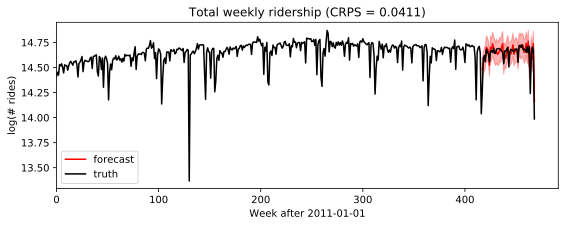

In [18]:
samples = forecaster(data[:T1], covariates, num_samples=1000)
p10, p50, p90 = quantile(samples, (0.1, 0.5, 0.9)).squeeze(-1)
crps = eval_crps(samples, data[T1:])

plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(data, 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(0, None)
plt.legend(loc="best");

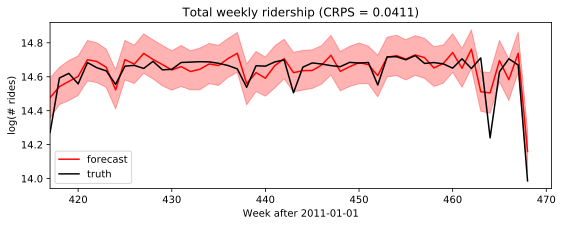

In [19]:
plt.figure(figsize=(9, 3))
plt.fill_between(torch.arange(T1, T2), p10, p90, color="red", alpha=0.3)
plt.plot(torch.arange(T1, T2), p50, 'r-', label='forecast')
plt.plot(torch.arange(T1, T2), data[T1:], 'k-', label='truth')
plt.title("Total weekly ridership (CRPS = {:0.3g})".format(crps))
plt.ylabel("log(# rides)")
plt.xlabel("Week after 2011-01-01")
plt.xlim(T1, None)
plt.legend(loc="best");

## Backtesting

To compare our Gaussian `Model2` and Stable `Model3` we'll use a simple [backtesting()](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.evaluate.backtest) helper. This helper by default evaluates three metrics: [CRPS](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.evaluate.eval_crps) assesses distributional accuracy of heavy-tailed data, [MAE](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.evaluate.eval_mae) assesses point accuracy of heavy-tailed data, and [RMSE](http://docs.pyro.ai/en/latest/contrib.forecast.html#pyro.contrib.forecast.evaluate.eval_rmse) assesses accuracy of Normal-tailed data. The one nuance here is to set `warm_start=True` to reduce the need for random restarts.

In [20]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows2 = backtest(data, covariates, Model2,
                    min_train_window=104, test_window=52, stride=26,
                    forecaster_options={"learning_rate": 0.1, "log_every": 1000,
                                        "warm_start": True})

INFO 	 Training on window [0:104], testing on window [104:156]
INFO 	 step    0 loss = 3534.09
INFO 	 step 1000 loss = 0.11251
INFO 	 Training on window [0:130], testing on window [130:182]
INFO 	 step    0 loss = 0.238584
INFO 	 step 1000 loss = -0.184576
INFO 	 Training on window [0:156], testing on window [156:208]
INFO 	 step    0 loss = 0.62968
INFO 	 step 1000 loss = -0.0259982
INFO 	 Training on window [0:182], testing on window [182:234]
INFO 	 step    0 loss = 0.195288
INFO 	 step 1000 loss = -0.120416
INFO 	 Training on window [0:208], testing on window [208:260]
INFO 	 step    0 loss = 0.188322
INFO 	 step 1000 loss = -0.18523
INFO 	 Training on window [0:234], testing on window [234:286]
INFO 	 step    0 loss = 0.0471417
INFO 	 step 1000 loss = -0.185852
INFO 	 Training on window [0:260], testing on window [260:312]
INFO 	 step    0 loss = 0.00251847
INFO 	 step 1000 loss = -0.246146
INFO 	 Training on window [0:286], testing on window [286:338]
INFO 	 step    0 loss = -0.0

CPU times: user 1min 51s, sys: 848 ms, total: 1min 52s
Wall time: 1min 53s


In [21]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
windows3 = backtest(data, covariates, Model3,
                    min_train_window=104, test_window=52, stride=26,
                    forecaster_options={"learning_rate": 0.1, "log_every": 1000,
                                        "warm_start": True})

INFO 	 Training on window [0:104], testing on window [104:156]
INFO 	 step    0 loss = 1849.22
INFO 	 step 1000 loss = 0.543365
INFO 	 Training on window [0:130], testing on window [130:182]
INFO 	 step    0 loss = 2.51271
INFO 	 step 1000 loss = 0.0757928
INFO 	 Training on window [0:156], testing on window [156:208]
INFO 	 step    0 loss = 2.6663
INFO 	 step 1000 loss = 0.0912818
INFO 	 Training on window [0:182], testing on window [182:234]
INFO 	 step    0 loss = 1.97279
INFO 	 step 1000 loss = -0.00365819
INFO 	 Training on window [0:208], testing on window [208:260]
INFO 	 step    0 loss = 1.59146
INFO 	 step 1000 loss = -0.0871935
INFO 	 Training on window [0:234], testing on window [234:286]
INFO 	 step    0 loss = 1.34227
INFO 	 step 1000 loss = -0.103136
INFO 	 Training on window [0:260], testing on window [260:312]
INFO 	 step    0 loss = 1.21624
INFO 	 step 1000 loss = -0.214513
INFO 	 Training on window [0:286], testing on window [286:338]
INFO 	 step    0 loss = 1.0086
IN

CPU times: user 4min 8s, sys: 1.58 s, total: 4min 10s
Wall time: 4min 11s


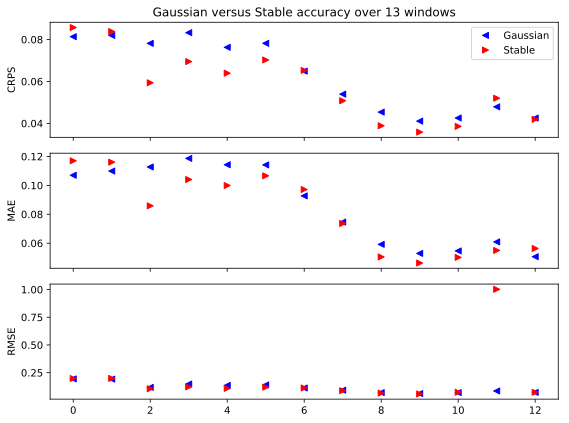

In [22]:
fig, axes = plt.subplots(3, figsize=(8, 6), sharex=True)
axes[0].set_title("Gaussian versus Stable accuracy over {} windows".format(len(windows2)))
axes[0].plot([w["crps"] for w in windows2], "b<", label="Gaussian")
axes[0].plot([w["crps"] for w in windows3], "r>", label="Stable")
axes[0].set_ylabel("CRPS")
axes[1].plot([w["mae"] for w in windows2], "b<", label="Gaussian")
axes[1].plot([w["mae"] for w in windows3], "r>", label="Stable")
axes[1].set_ylabel("MAE")
axes[2].plot([w["rmse"] for w in windows2], "b<", label="Gaussian")
axes[2].plot([w["rmse"] for w in windows3], "r>", label="Stable")
axes[2].set_ylabel("RMSE")
axes[0].legend(loc="best")
plt.tight_layout()

Note that RMSE is a poor metric for evaluating heavy-tailed data. Our stable model has such heavy tails that its variance is infinite, so we cannot expect RMSE to converge, hence occasional outlying points.